#### Student Name:
#### Student ID:

# Assignment 9

### GAN, chroma (MIDI) and pix2pix

Instructions: 

* This notebook is an interactive assignment; please read and follow the instructions in each cell. 

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook and printout as a PDF.


In this notebook we explore a style transfer application that tries to change the musical texture of a piece while maintaining the harmonic structure. In order to do so we train a pix2pix type of model that learns the relations between chroma and the musical texture (distribution of notes). For this purpose we extract chroma from MIDI data and learn a generator that complements the notes from a given texture. You can think about this as something similar to pix2pix that learns completion of image textures from a sketch that was mentioned in class. In the image GAN the contours for training are generated using an edge detection on a complete image.

# 1. Imports and Loading Data
Before running, please make sure to upload the following to your python directory
- reverse_pianoroll.py
- convert.py
- Classical_Music_Midi.zip and unzip it

In [1]:
!{__import__('sys').executable} -m pip install --upgrade --quiet librosa matplotlib numpy tensorflow pretty_midi music21

import pretty_midi
from utils import reverse_pianoroll, convert
import librosa

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [43]:
import random

In [2]:
import io

import pretty_midi

import music21
import music21.midi


def _pretty_midi_to_music21(o: pretty_midi.PrettyMIDI):
    f = io.BytesIO()
    o.write(f)
    
    mf = music21.midi.MidiFile()
    mf.readstr(f.getvalue())
    
    return mf

_midi_to_stream = music21.midi.translate.midiFileToStream

def _midi_stream(fp):
    mf = music21.midi.MidiFile()
    try:
        mf.open(fp)
    except:
        mf.openFileLike(fp)
    mf.read()
    mf.close()
    return _midi_to_stream(mf)   

In [33]:
def unzip(l): return zip(*list(l))

In [3]:
import numpy as np
import sys

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['figure.constrained_layout.use'] = True

In [5]:
#all necessary imports: use pip install [library name] to add to environment
#this notebook was run in 2019 with tensorflow version 1.15. some functions may or may not work with tensorflow > 2.0

#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.disable_v2_behavior()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from os import listdir
import glob

2022-07-24 22:31:19.736599: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
#add songs to data
import multiprocessing as mp

def _get_song(f):
    data = pretty_midi.PrettyMIDI(f)
    song = data.get_piano_roll(fs=16)
    song = convert.forward(song)
    # song = np.transpose(song) #if your code matrices aren't working, try uncommenting this. the convert.py file might not be updated
    return song

def _get_songs(files):
    with mp.Pool() as pool:
        return pool.map(_get_song, files)

def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    return _get_songs(files)

In [7]:
#custom function to extract chroma features from song
def _get_chroma(song):
    chroma = np.zeros(shape=(np.shape(song)[0], 12))
    for i in np.arange(np.shape(song)[0]): 
        for j in np.arange(78):
            if song[i][j] > 0:
                chroma[i][np.mod(j,12)] += 1
    return chroma

def _get_chromas(songs):
    with mp.Pool() as pool:
        return pool.map(_get_chroma, songs)

get_chromas = _get_chromas

In [8]:
songs = get_songs('./chordgan/Classical_Music_Midi/mozart')
chromas = get_chromas(songs)
print ("{} songs processed".format(len(songs)))
print ("{} chromas processed".format(len(chromas)))

21 songs processed
21 chromas processed


#### Exploring the song and chroma representations

Looking at a random song segment

In [9]:
song = songs[0]
np.shape(song)

(834, 156)

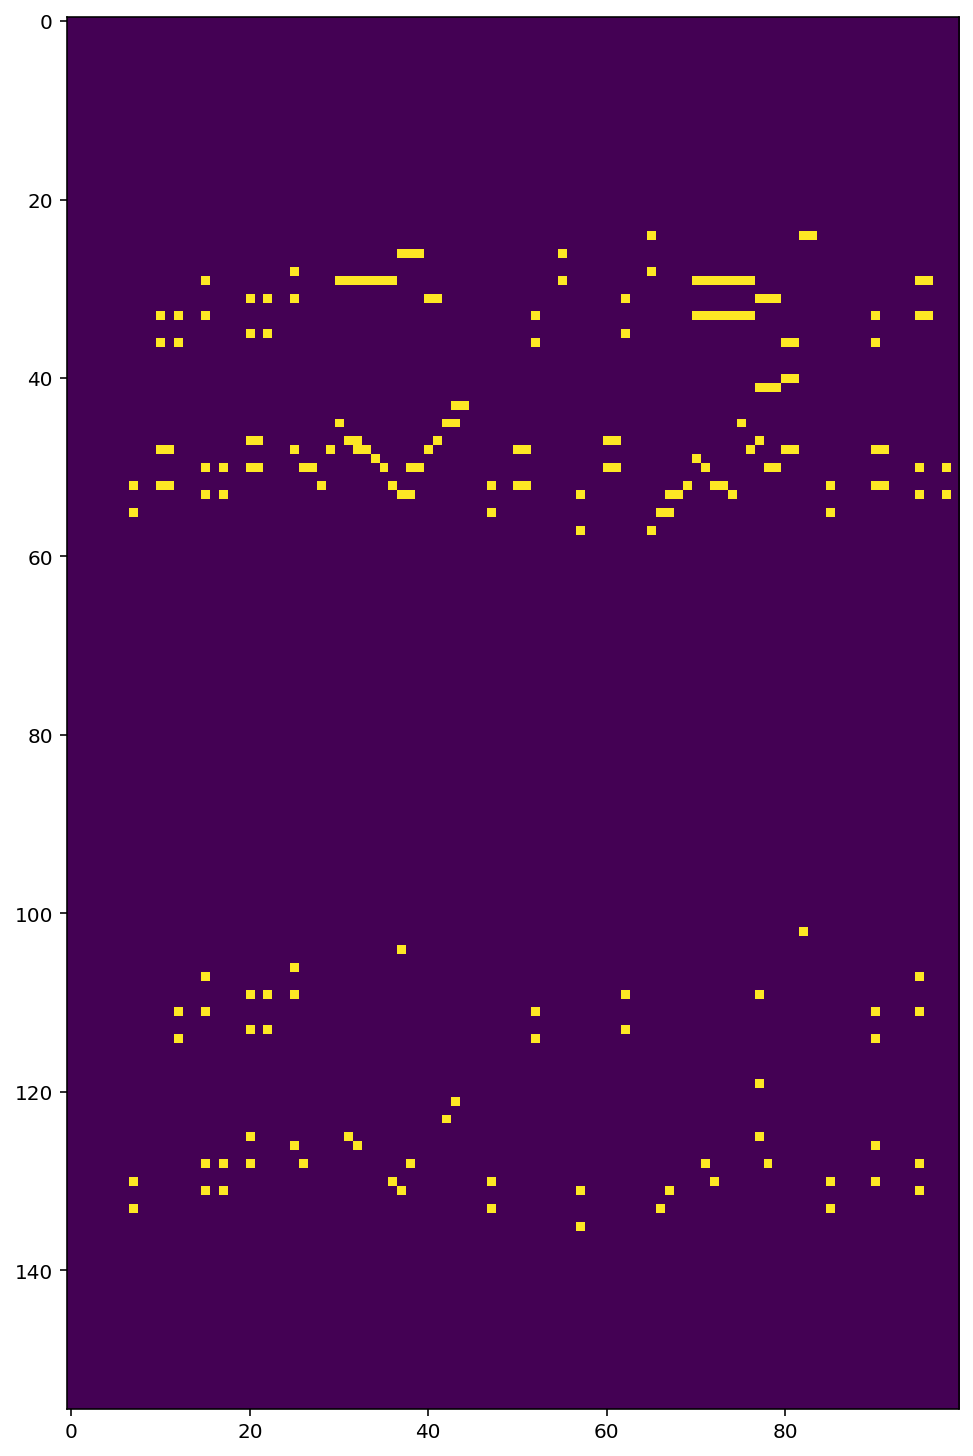

In [10]:
plt.figure(figsize = (20,10))
plt.imshow(100*song[:100,:].T, aspect = 'equal')

In [11]:
chroma = chromas[0]
np.shape(chroma)

(834, 12)

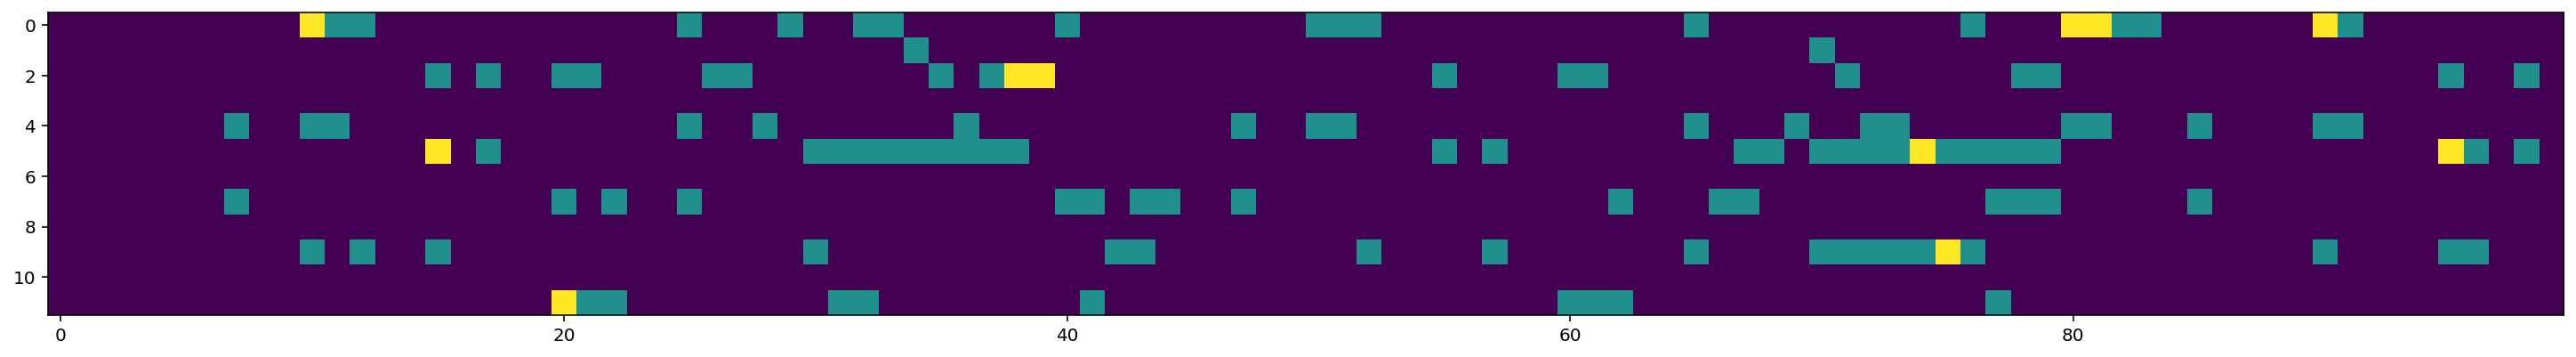

In [12]:
plt.figure(figsize = (20,10))
plt.imshow(100*chroma[:100,:].T, aspect = 'equal')

##### Question 1 [10 points]
Describe what the chromas function does. In your answer refer to musical terms of note names and octave numbers. How does that resemble or differ from the chroma feature that is computed for audio spectrum? Use the figures to demonstrate the explanation.

Hint: Refresh the musical terms by looking at Slides 1 and consider what type of music anaylsis the audio chroma is used for. If you are interested more in musical theory you may also consider the concepts of "pitch class" and "music set theory" that are explained in https://en.wikipedia.org/wiki/Musical_note and https://en.wikipedia.org/wiki/Set_theory_%28music%29

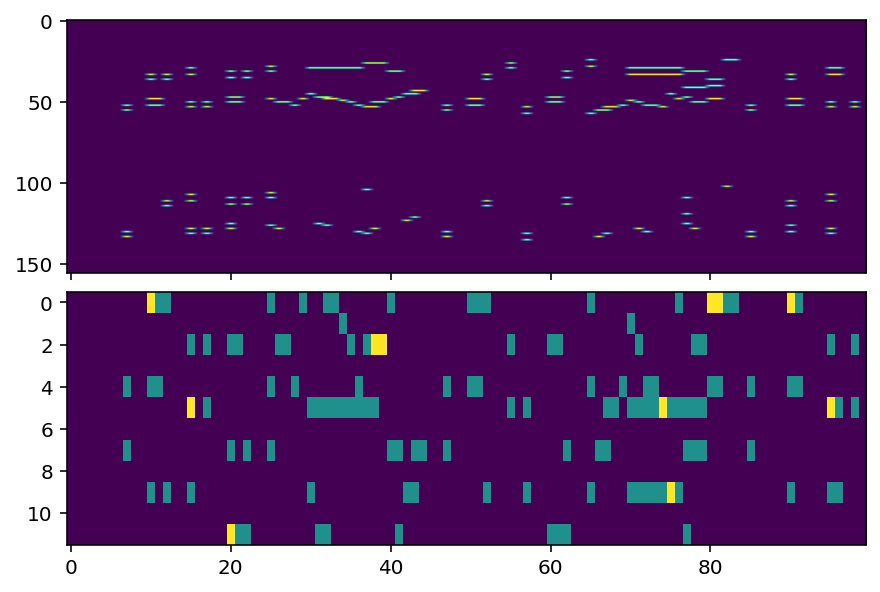

In [13]:
fig, axes = plt.subplots(
    nrows = 2, ncols = 1, 
    sharex = True
)

axes[0].imshow(song[:100,:].T)
axes[1].imshow(chroma[:100,:].T)

fig.show()

``` your response here```

The chroma function captures ["harmonic and melodic characteristics of music"](https://en.wikipedia.org/wiki/Chroma_feature) by categorizing notes to pitch classes. The chroma graph visualizes the distribution of notes.

# 2. Setting Up GAN Model

In [14]:
lowest_note = 0 #the index of the lowest note on the piano roll
highest_note = 78 #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 4 #This is the number of timesteps that we will create at a time
X_dim = 2*note_range*num_timesteps #This is the size of the visible layer. 
Z_dim = 12*num_timesteps
n_hidden = 50 #This is the size of the hidden layer

print(X_dim,Z_dim)

624 48


##### Question 2 [10 points]

Explain what aspects of music (pitch, rhythm, note duration) are captured by the latent random Z? In your answer refer to the representaiton of the song data. Note how song matrix differs from standard pianoroll.

``` your response here```

Pitch and rhythm. The song matrix is a transposed pianoroll. Variable `Z` is what the chroma matrix should be assigned to.

In [15]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [16]:
#setting up model, discriminator weights and biases
X = tf.placeholder(tf.float32, shape=[None, X_dim])


D_W1 = tf.Variable(xavier_init([X_dim+Z_dim, 512]))
D_b1 = tf.Variable(tf.zeros(shape=[512]))

D_W2 = tf.Variable(xavier_init([512, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

In [17]:
#setting up model, generator weights and biases

#z is the space we're generating from
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [18]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [19]:
def discriminator(x,c):
    D_h1 = tf.nn.relu(tf.matmul(tf.concat([x,c],1), D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [20]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        plt.imshow(sample.reshape(78, 30), cmap='Greys_r')


    return fig

In [21]:
G_sample = generator(Z)

In [22]:
D_real, D_logit_real = discriminator(X,Z)

In [23]:
D_fake, D_logit_fake = discriminator(G_sample,Z)

##### Question 3 [10 points]
In standard GAN, the discriminator receives as input true or fake (generated) data only. Explain why in our case the disrciminator receives as input both the data and an additional variable Z? How this Z differs from the usual GAN input of a random vector?

``` your response here```

We want the model to learn the chroma features of songs in addition to the audio signatures.
`Z` differs from the usual input of a random vector in that it's not randomized but rather derived from the preexisting data (the chroma features).

In [24]:
# Alternative losses:
# -------------------
def _get_D_G_losses(Lambda):
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
    D_loss = D_loss_real + D_loss_fake
    G_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
    G_loss_L1 = tf.reduce_mean(tf.losses.mean_squared_error(X,G_sample))
    G_loss = G_loss_fake + Lambda*G_loss_L1
    return D_loss, G_loss

D_loss, G_loss = _get_D_G_losses(Lambda = 100)

In [25]:
# optimizing functions
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

##### Question 4 [10 points]
Explain the two components of the discriminator loss in the D_loss expression. Why the real loss uses tf.ones_like andthe fake loss uses tf.zeros_like in the cross entory loss? What are the statistical distributions (which datasets are used) in computational of the real and fake losses. In your answers you may either include an equation image or write the loss equaiton in latex mathamtical notation inside Markdown cell.

``` your response here ```

Real loss uses `tf.ones_like` and the fake loss uses `tf.zeros_like` because we want them to complement each other so that the total loss takes into account the performance of both. For the real and fake losses we use the real data and the forged data (generated by the generator) respectively.

Loss function
$$
L(G, D)=\int_{x}\left({ }^{*} p_{r}(x) \log (D(x))+p_{g}(x) \log (1-D(x))\right) d x
$$

- Discriminator:
    $$
    \begin{gathered}
    \frac{\partial}{\partial D(x)}\left(p_{\text {data }}(x) \log (D(x))+p_{g}(x) \log (1-D(x))=0\right. \\
    D(x)=\frac{p_{\text {data }}(x)}{p_{\text {data }}(x)+p_{g}(x)}
    \end{gathered}
    $$
- Generator:
    $$
    \begin{gathered}
    \int\left[p_{\text {data }}(x) \log \left(\frac{p_{\text {data }}(x)}{p_{\text {data }}(x)+p_{g}(x)}\right)+p_{g}(x) \log \left(1-\frac{p_{\text {data }}(x)}{p_{\text {data }}(x)+p_{g}(x)}\right)\right] d x \\
    K L\left[p_{\text {data }}(x) \| \frac{p_{\text {data }}(x)+p_{g}(x)}{2}\right]+K L\left[p_{g}(x) \| \frac{p_{\text {data }}(x)+p_{g}(x)}{2}\right]-\log (4) \\
    L\left(G, D^{*}\right)=2 D_{J S}\left(p_{r} \| p_{g}\right)-2 \log 2
    \end{gathered}
    $$

##### Question 5 [10 points]
In the generator loss G_loss we add an L1 loss. What does it represent? Why do you think we might want to add the L1 loss to the GAN model? We will explore this question further down the assignment, so at this point write down your best explanation based on the equations themselves without running any experiments.

``` your response here ```

Since L1 loss is for regression tasks, its role in the model is to help analyze how well the mathematical relationships between the variables time and pitch are represented. 

# 3. Training GAN Model

In [26]:
def _prep_song_chroma(songs):
    data_song_chroma = []
    for song, chroma in zip(songs, get_chromas(songs)):      
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements    
        song = np.asarray(song)     
        #print(np.shape(song))  
        song_steps = int(np.floor(song.shape[0] / num_timesteps))
        song = song[:song_steps * num_timesteps]
        song = np.reshape(song, (song_steps, song.shape[1] * num_timesteps))

        chroma = np.asarray(chroma)
        #print(np.shape(chroma))
        chroma = chroma[:song_steps * num_timesteps]
        chroma = np.reshape(chroma, (song_steps, chroma.shape[1] * num_timesteps))  
        data_song_chroma.append((song, chroma))
    return data_song_chroma

def _train(
    sess,
    songs,
    D_solver, D_loss,
    G_solver, G_loss,
    num_epochs = 200000,
    batch_size = 100,
    checkpoint_fn = None
):
    data_song_chroma = _prep_song_chroma(songs)
    
    i = 0
    while i <= num_epochs:
        for song, chroma in data_song_chroma:      
            batch_size = min(batch_size, len(song))

            # Train the RBM on batch_size examples at a time
            for ind in range(0, len(song), batch_size):
                r = np.s_[ind:(ind + batch_size)]
                X_mb, ch = song[r], chroma[r]

                _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: ch})
                _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, Z: ch})

                if checkpoint_fn is not None:
                    checkpoint_fn(sess, i, num_epochs, D_loss_curr, G_loss_curr, X_mb, ch)
                    
                i += 1
                
                
def _checkpoint_epoch(sess, epoch, num_epochs, D_loss_curr, G_loss_curr, X_mb, ch):
    if epoch % 1000 == 0:
        print(f'{epoch}/{num_epochs} D_Loss: {D_loss_curr:.4} G_Loss: {G_loss_curr:.4}')

In [27]:
def _generate_sample(sess, ch, S_cutoff = .5):
    samples = sess.run(G_sample, feed_dict = {Z: ch})
    S = np.reshape(samples, (ch.shape[0] * num_timesteps, 2 * note_range))
    C = np.reshape(ch, (ch.shape[0] * num_timesteps, 12))
    thresh_S = np.transpose(S >= S_cutoff)
    return reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(thresh_S), fs = 16), S, C

In [56]:
num_epochs = 20000 #200000
batch_size = 50000

S_cutoff = .5

def _checkpoint(sess, epoch, num_epochs, D_loss_curr, G_loss_curr, X_mb, ch):
    _checkpoint_epoch(sess, epoch, num_epochs, D_loss_curr, G_loss_curr, X_mb, ch)
    if epoch % (num_epochs // 4) == 0:
        sample, S, C = _generate_sample(sess, ch, S_cutoff = S_cutoff)
        
        fig, axes = plt.subplots(
            nrows = 1, ncols = 2
        )
        axes[0].set(title = 'S')
        axes[0].imshow(S)
        axes[1].set(title = 'C')
        axes[1].imshow(C)
        fig.show()
        
        _midi_to_stream(_pretty_midi_to_music21(sample)).show('midi')

In [57]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

2022-07-24 23:48:23.329406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9649 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


0/20000 D_Loss: 1.294 G_Loss: 30.84


1000/20000 D_Loss: 0.1506 G_Loss: 5.384
2000/20000 D_Loss: 0.07582 G_Loss: 5.949
3000/20000 D_Loss: 0.00116 G_Loss: 23.81
4000/20000 D_Loss: 0.001833 G_Loss: 16.5
5000/20000 D_Loss: 0.0004971 G_Loss: 12.75


6000/20000 D_Loss: 5.597e-08 G_Loss: 27.95
7000/20000 D_Loss: 0.0007161 G_Loss: 13.66
8000/20000 D_Loss: 1.044e-05 G_Loss: 17.53
9000/20000 D_Loss: 4.455e-06 G_Loss: 20.95
10000/20000 D_Loss: 8.85e-07 G_Loss: 22.31


11000/20000 D_Loss: 1.889e-06 G_Loss: 26.72
12000/20000 D_Loss: 8.146e-06 G_Loss: 26.48
13000/20000 D_Loss: 4.515e-06 G_Loss: 31.28
14000/20000 D_Loss: 5.681e-06 G_Loss: 25.94
15000/20000 D_Loss: 9.792e-07 G_Loss: 20.06


16000/20000 D_Loss: 2.437e-07 G_Loss: 30.1
17000/20000 D_Loss: 6.041e-07 G_Loss: 26.75
18000/20000 D_Loss: 9.742e-09 G_Loss: 28.8
19000/20000 D_Loss: 5.93e-08 G_Loss: 34.75
20000/20000 D_Loss: 1.905e-08 G_Loss: 33.6


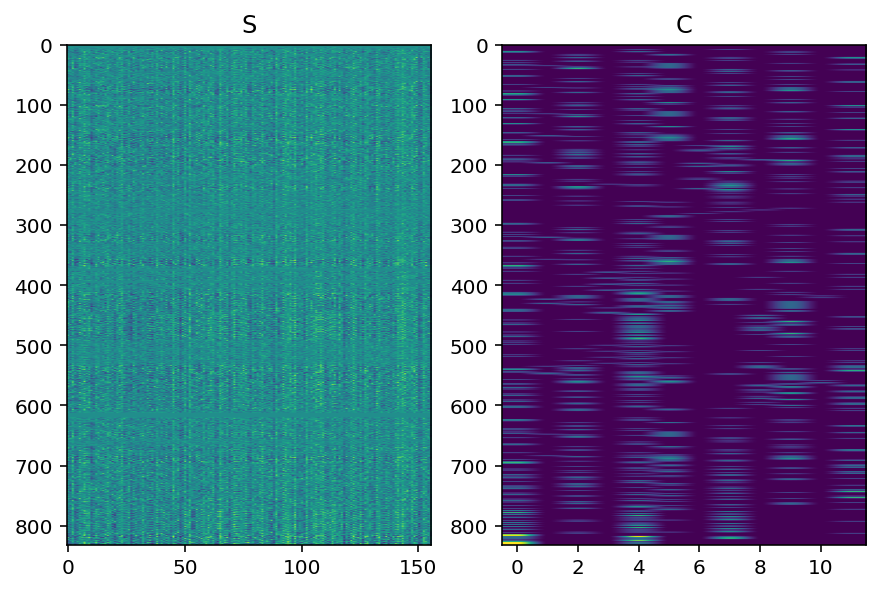

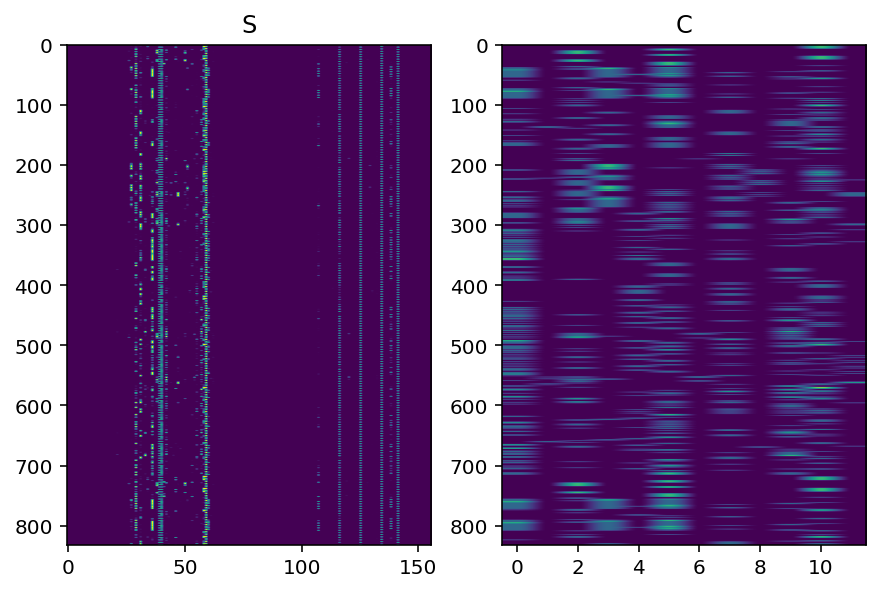

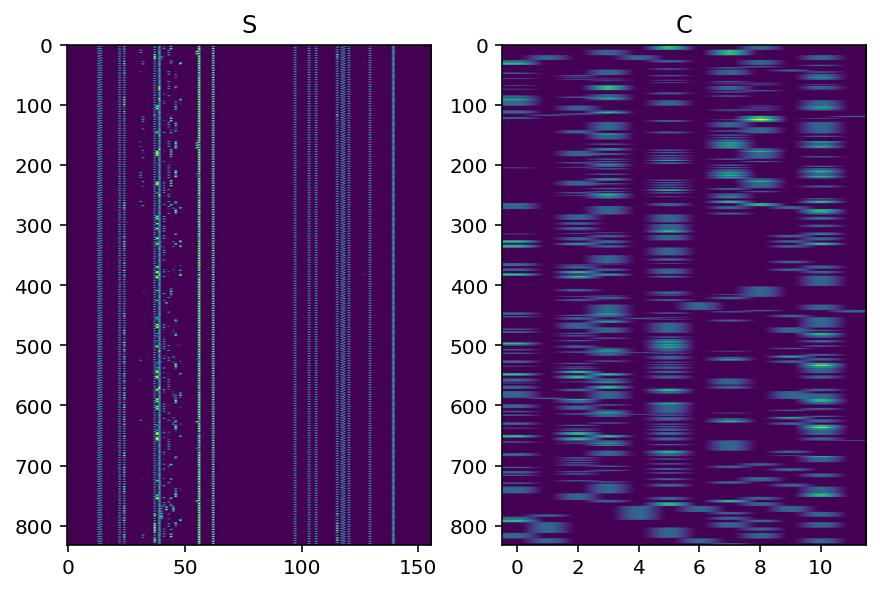

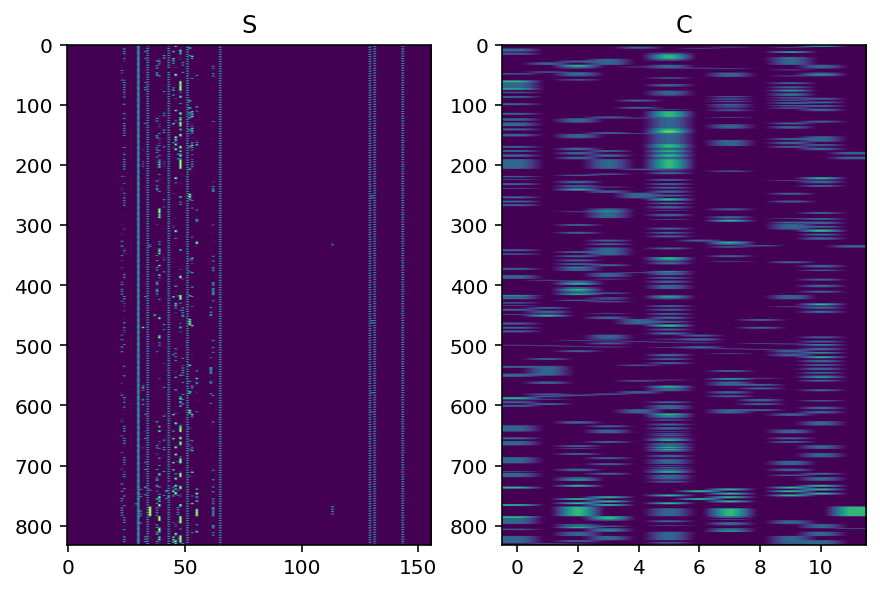

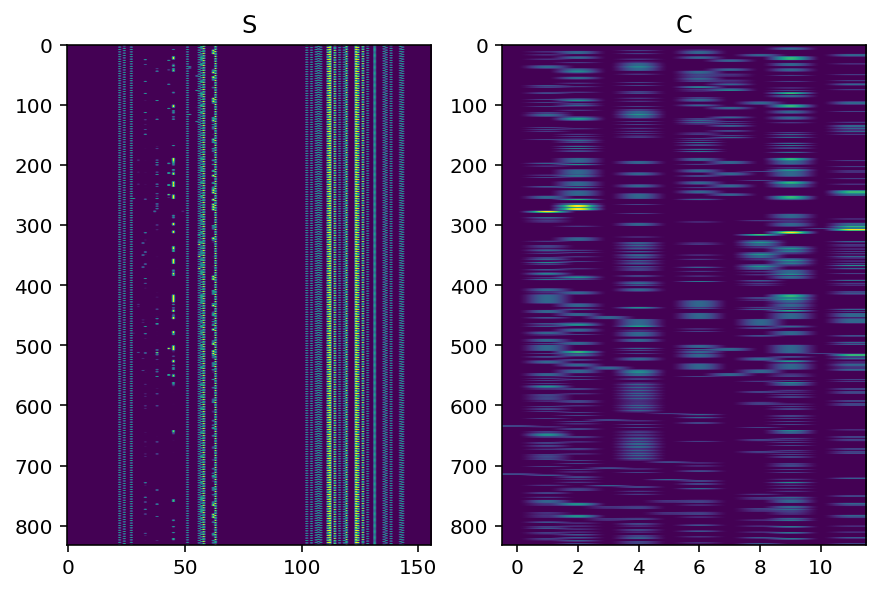

In [58]:
_train(
    sess,
    songs, 
    D_solver, D_loss,
    G_solver, G_loss,
    num_epochs = num_epochs, 
    batch_size = batch_size, 
    checkpoint_fn = _checkpoint
)

# 4. Style Transfer with a New Genre Dataset

In this part we will explore using the trained GAN to compose new music according to the harmonic structure of another musical input. In a way this comprises of a style transfer between the input music that belongs to style A and the output music that is generated using GAN trained on style B. In the example we will used J.S.Bach as our input (Style A) and output music in Mozart's style that was use to train our GAN (Style B). The new Mozart piece should follow the harmonic structure (chord progressions) of the Bach input.

In [59]:
#for testing, we will be using a different composer dataset to input into the generator here.
test_song = get_songs("./chordgan/Classical_Music_Midi/bach")
test_chromaz = get_chromas(test_song)
print ("{} songs processed".format(len(test_song)))
print ("{} songs processed".format(len(test_chromaz)))

3 songs processed
3 songs processed


In [60]:
def _experiment_style_transfer(sess, songs, chromas, S_cutoff = .5):
    for s, c in zip(songs, chromas):
        chroma = np.asarray(c)
        chroma = chroma[:np.floor(chroma.shape[0]/num_timesteps).astype(int)*num_timesteps]
        chroma = np.reshape(chroma, [int(chroma.shape[0]/num_timesteps), chroma.shape[1]*num_timesteps])

        sample, S, C = _generate_sample(sess, chroma, S_cutoff = S_cutoff)
        yield sample, S, C

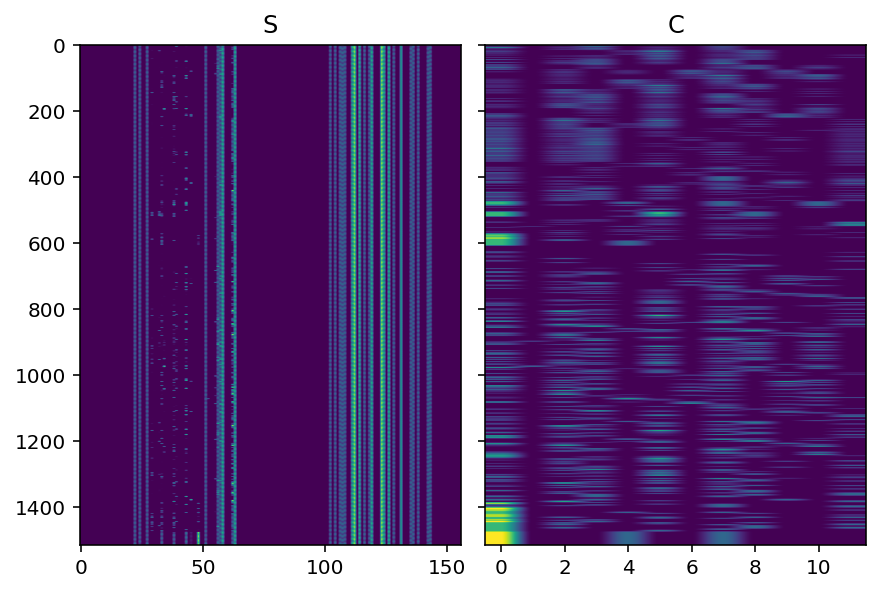

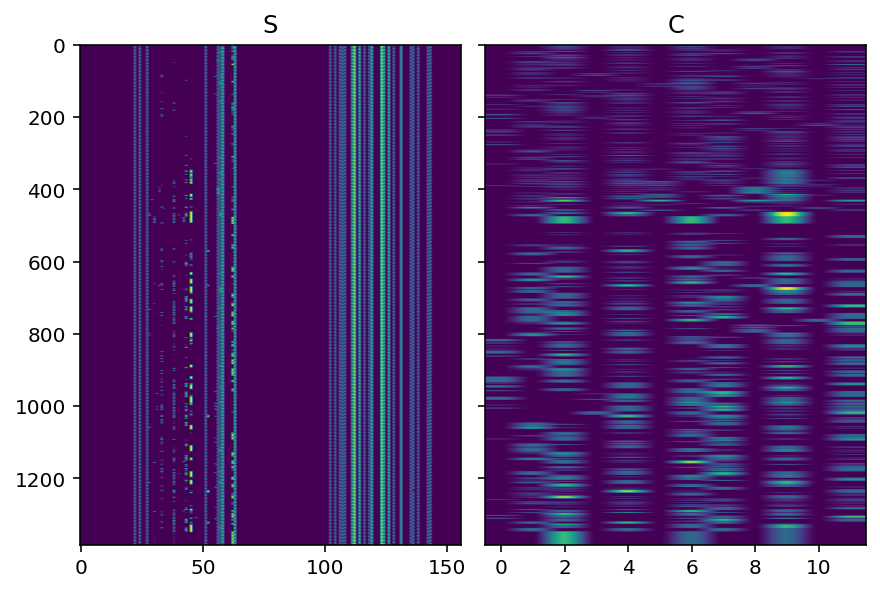

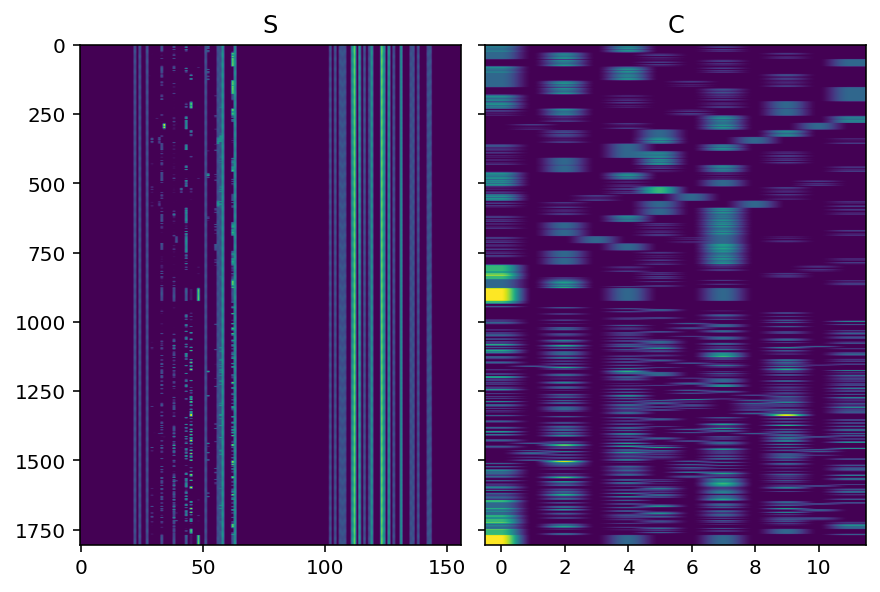

In [61]:
for sample, S, C in _experiment_style_transfer(sess, test_song, test_chromaz):
    fig, axes = plt.subplots(
        nrows = 1, ncols = 2,
        sharey = True
    )
    axes[0].set(title = 'S')
    axes[0].imshow(S)
    axes[1].set(title = 'C')
    axes[1].imshow(C)
    fig.show()

    _midi_to_stream(_pretty_midi_to_music21(sample)).show('midi')

##### Question 6 [10 points]
Open the conversion results in a musical MIDI software (such as Musescore) and observe/listen to the results. Write down your impressions about the quality of the musical texture style transfer - did the harmonic structure follow the Bach input? How did the notes distribution (choice of pitches and durations) change relative to the original Bach piece? Does the S_cutoff parameter affect the outcome, and if so, how? 

Summarize your findings and suggest some conclusions. Can you point to any musical aspects that were poorly modeled and ideas of improvement? 

In [62]:
for f in glob.glob('chordgan/Classical_Music_Midi/bach/*.mid*'):
    _midi_stream(f).show('midi')

/home/r8chen/.local/lib/python3.9/site-packages/music21/midi/translate.py:883: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=7, channel=None, data=b'Copyright 2004 by Bernd Kr\xfcger.'>; getting generic Instrument
  warnings.warn(


/home/r8chen/.local/lib/python3.9/site-packages/music21/midi/translate.py:883: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Pr\xe4ludium und Fuge in D-Dur, BWV 850'>; getting generic Instrument
  warnings.warn(
/home/r8chen/.local/lib/python3.9/site-packages/music21/midi/translate.py:883: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=8, channel=None, data=b'Copyright 1997 by Bernd Kr\xfcger.'>; getting generic Instrument
  warnings.warn(


/home/r8chen/.local/lib/python3.9/site-packages/music21/midi/translate.py:883: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=8, channel=None, data=b'Copyright 2004 by Bernd Kr\xfcger.'>; getting generic Instrument
  warnings.warn(


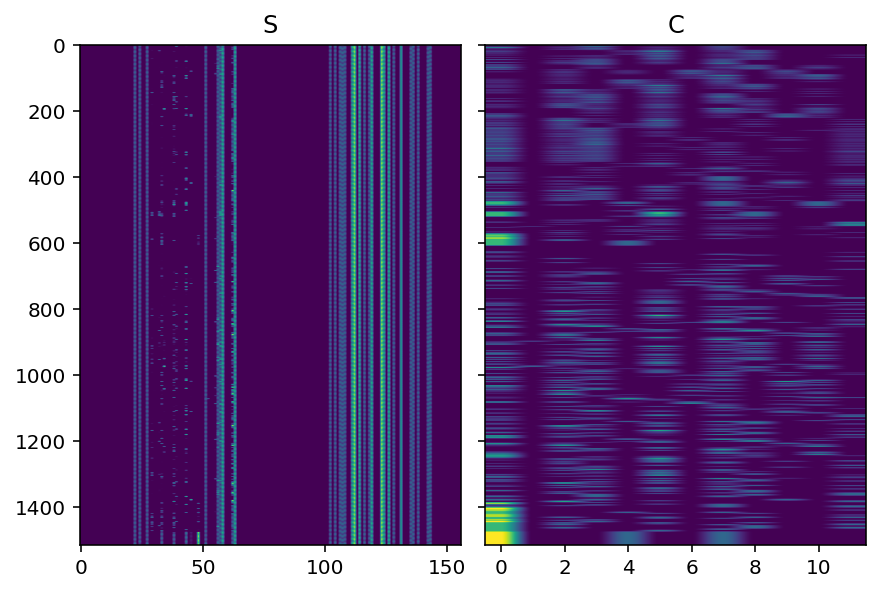

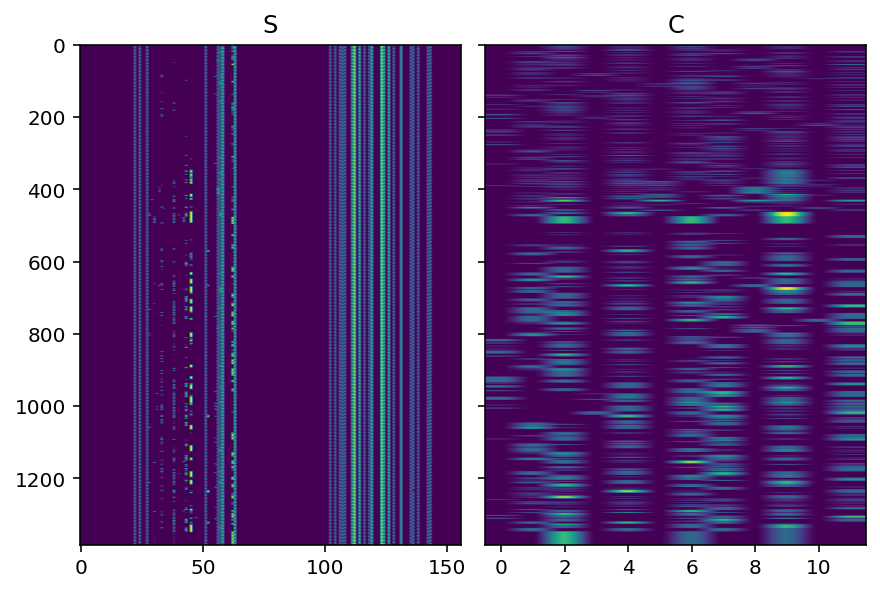

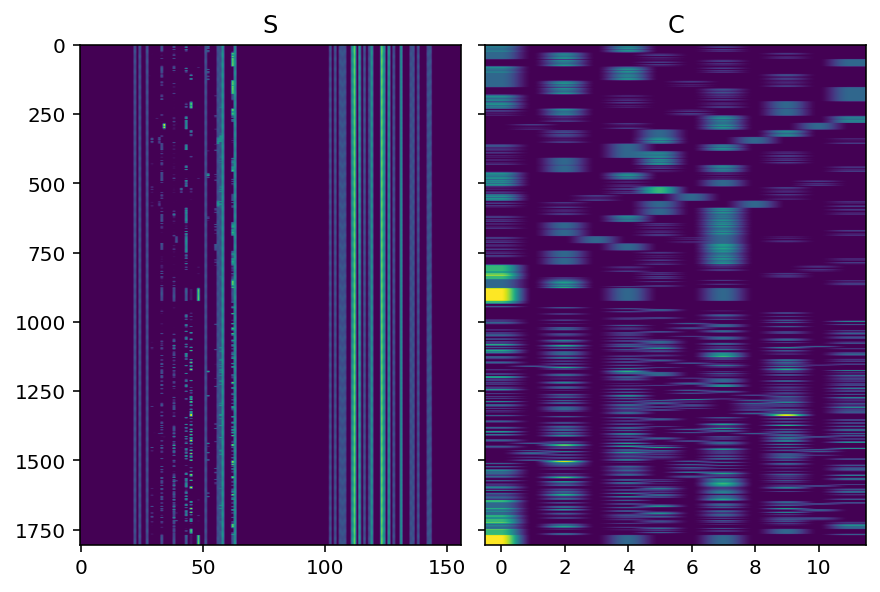

In [63]:
for sample, S, C in _experiment_style_transfer(sess, test_song, test_chromaz, S_cutoff = .1):
    fig, axes = plt.subplots(
        nrows = 1, ncols = 2,
        sharey = True
    )
    axes[0].set(title = 'S')
    axes[0].imshow(S)
    axes[1].set(title = 'C')
    axes[1].imshow(C)
    fig.show()

    _midi_to_stream(_pretty_midi_to_music21(sample)).show('midi')

``` your response here ```

- Did the harmonic structure follow the Bach input? 
    Yes.
- How did the notes distribution (choice of pitches and durations) change relative to the original Bach piece? 
    The note distribution becomes more random and less musical.
- Does the `S_cutoff` parameter affect the outcome, and if so, how?
    `S_cutoff` determines the generator's sensitity to note changes. 
- Can you point to any musical aspects that were poorly modeled and ideas of improvement?
    We train the model solely based on chroma features (pitch classes). One potential way to improve the model performance is to take into account other musical features such as timbre and tempo. This involves not limiting the scope of our data to only piano music.

# 5. Further experiments

##### Question 7 & 8: [total 40 points]

Choose two of the experiments and report their results:

1. Explore style transfer between more distant styles: For this purpose you may use the Pop_Music_Midi dataset and repeat the Style Transfer Experiment between Classical and Pop music (and vice versa). Report your findings in qualitative ways and submit the midi results together with your explanation. [20 Points]

2. Expermment with L1 distance: retrain the GAN model with very small and very large Lambda. What are the effects of such changes? When is the texture of the output more or less musical? Are the harmonic progressions of the input followed or ignored? Any other observations? [20 Points]

3. Create your own song: use the leadsheet2chroma.py file provided to create a Mozart style composition from your own leadsheet input. Provide the leadsheet in text format and the midi file results. Report your observations about the musical quality of the results. You may alter the leadsheet2chroma.py to fit other chords if you wish, or train GAN in a style different then Mozart. [20 Points]



## Style Transfer between Classical and Pop

In [30]:
classical = _get_songs(glob.glob('chordgan/Classical_Music_Midi/**/*.mid*'))
classical_chromas = get_chromas(classical)

pop = _get_songs(glob.glob('chordgan/Pop_Music_Midi/*.mid*'))
pop_chromas = get_chromas(pop)

/opt/conda/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  

/opt/conda/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  

/opt/conda/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  

In [49]:
def _train_st(
    songs, 
    n_epochs = 10000, 
    batch_size = 10000, 
    Lambda = 500
):
    sess = tf.Session()

    D_loss, G_loss = _get_D_G_losses(Lambda = Lambda)
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list = theta_D)
    G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list = theta_G)

    sess.run(tf.global_variables_initializer())

    return sess, _train(
        sess,
        songs, 
        D_solver, D_loss,
        G_solver, G_loss,
        num_epochs = n_epochs, 
        batch_size = batch_size, 
        checkpoint_fn = _checkpoint
    )

### Classical to Pop

2022-07-24 23:27:39.652557: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9649 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


0/10000 D_Loss: 1.223 G_Loss: 155.2


1000/10000 D_Loss: 0.3919 G_Loss: 13.8
2000/10000 D_Loss: 0.2802 G_Loss: 13.89


3000/10000 D_Loss: 0.1023 G_Loss: 14.06
4000/10000 D_Loss: 0.008871 G_Loss: 35.87
5000/10000 D_Loss: 0.4467 G_Loss: 13.29


6000/10000 D_Loss: 0.06815 G_Loss: 24.97
7000/10000 D_Loss: 2.253 G_Loss: 15.48


8000/10000 D_Loss: 3.277 G_Loss: 17.06
9000/10000 D_Loss: 0.006824 G_Loss: 35.74
10000/10000 D_Loss: 0.0001591 G_Loss: 45.46


11000/10000 D_Loss: 2.381e-06 G_Loss: 52.77
12000/10000 D_Loss: 0.0007862 G_Loss: 46.62


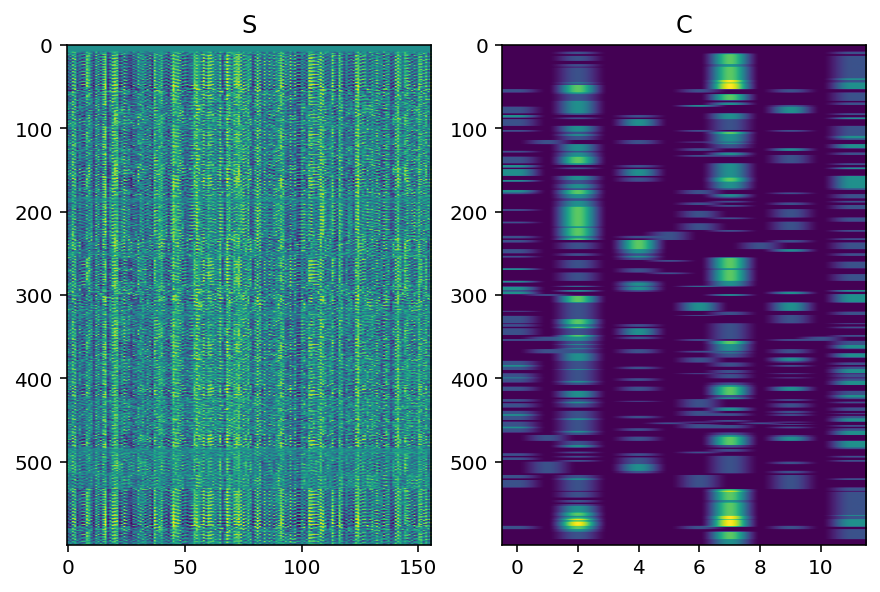

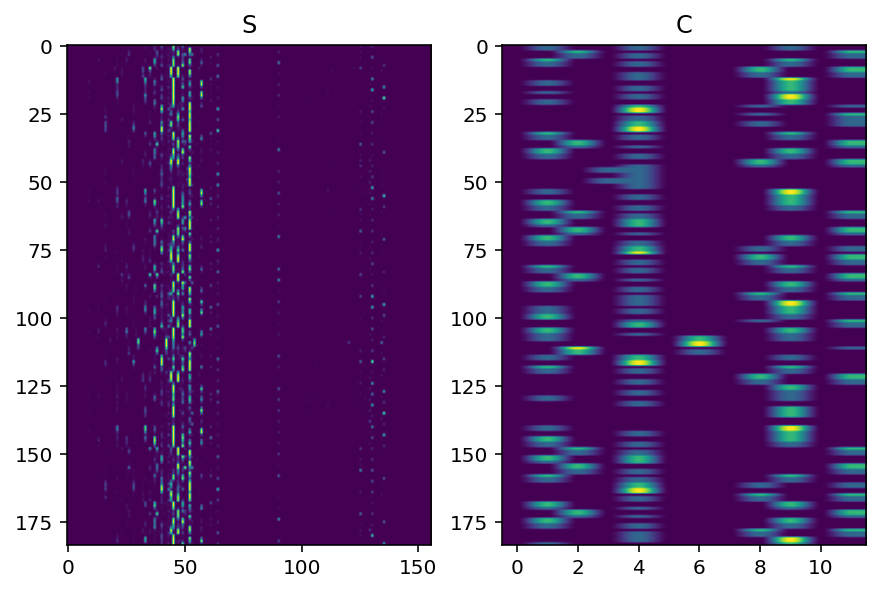

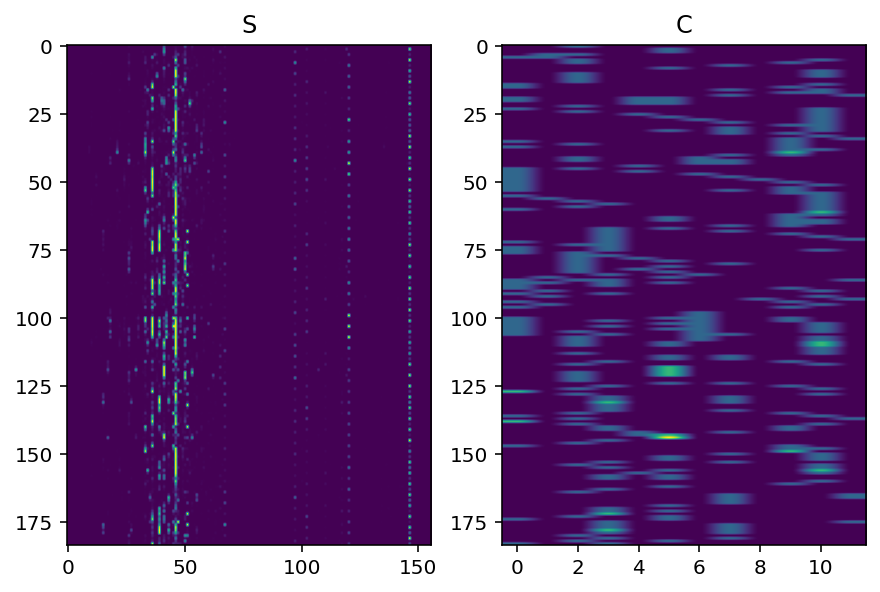

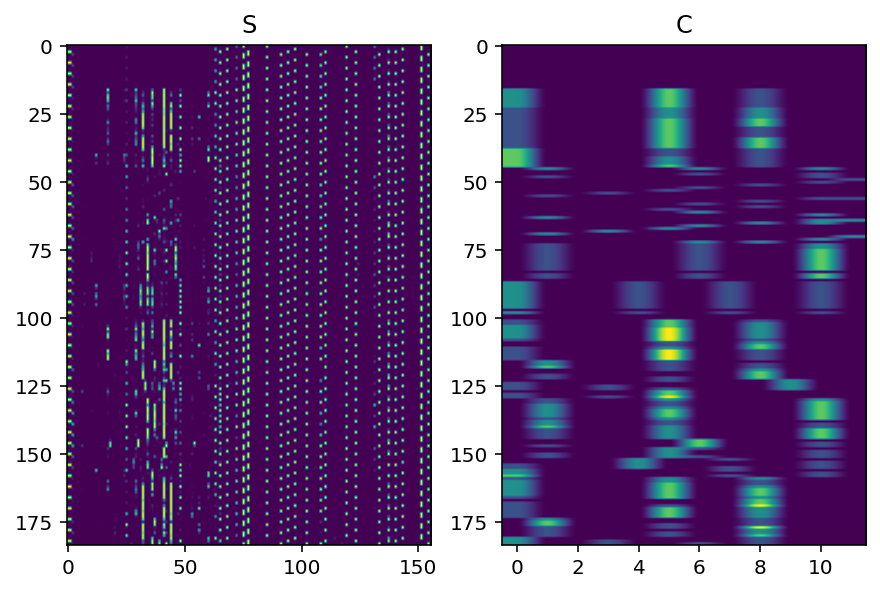

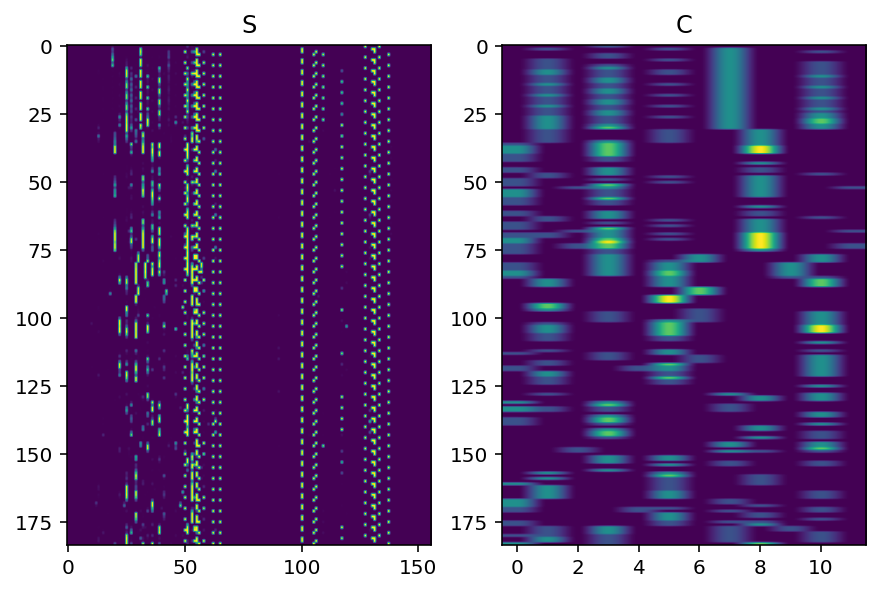

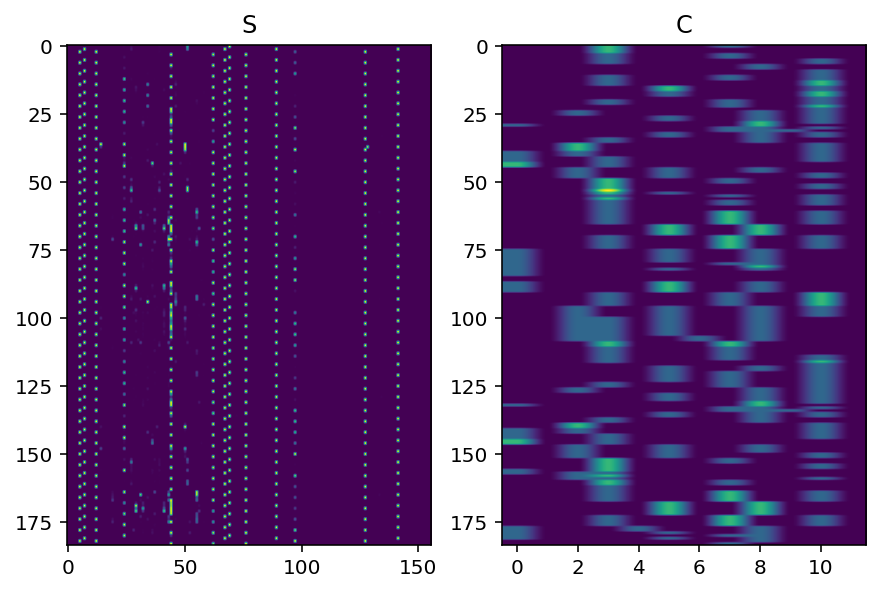

In [50]:
sess_classical, _ = _train_st(classical)

In [51]:
n_samples = 4

for sample, _, _ in (
    _experiment_style_transfer(
        sess_classical, *unzip(
            random.sample(
                list(zip(pop, pop_chromas)), 
                k = n_samples
            )
        )
    )
):
    _midi_to_stream(_pretty_midi_to_music21(sample)).show('midi')

In [52]:
for f in np.random.choice(glob.glob('chordgan/Pop_Music_Midi/*.mid*'), size = 4, replace = False):
    print(f)
    _midi_stream(f).show('midi')

chordgan/Pop_Music_Midi/Shake It Off - Chorus.midi


/home/r8chen/.local/lib/python3.9/site-packages/music21/midi/translate.py:2328: TranslateWarning: Electric Piano specified 1-indexed MIDI channel 1 but acceptable channels were [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16]. Defaulting to channel 1.
  warnings.warn(
/home/r8chen/.local/lib/python3.9/site-packages/music21/midi/translate.py:2328: TranslateWarning: Glockenspiel specified 1-indexed MIDI channel 1 but acceptable channels were [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16]. Defaulting to channel 1.
  warnings.warn(


chordgan/Pop_Music_Midi/Best Day Of My Life - Chorus.midi


chordgan/Pop_Music_Midi/Feel So Close - Verse.midi


chordgan/Pop_Music_Midi/Blank Space - Verse.midi


### Pop to Classical

2022-07-24 23:29:52.855105: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9649 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


0/10000 D_Loss: 1.363 G_Loss: 152.7


1000/10000 D_Loss: 0.7013 G_Loss: 7.284
2000/10000 D_Loss: 0.7937 G_Loss: 2.806


3000/10000 D_Loss: 0.1179 G_Loss: 9.423
4000/10000 D_Loss: 0.2687 G_Loss: 8.127
5000/10000 D_Loss: 0.01868 G_Loss: 12.47


6000/10000 D_Loss: 0.9502 G_Loss: 6.436
7000/10000 D_Loss: 0.6527 G_Loss: 8.421


8000/10000 D_Loss: 0.4425 G_Loss: 8.68
9000/10000 D_Loss: 0.3808 G_Loss: 7.924
10000/10000 D_Loss: 1.208 G_Loss: 4.476


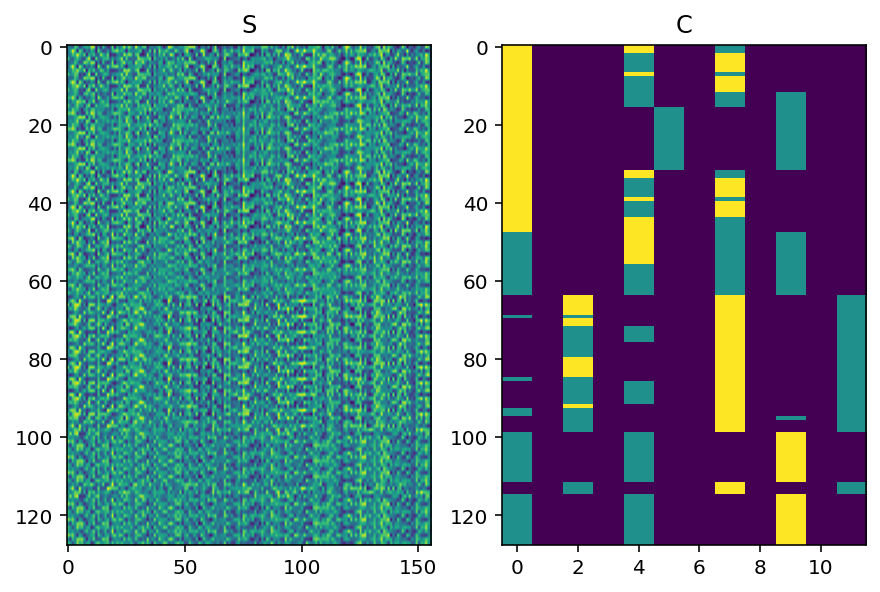

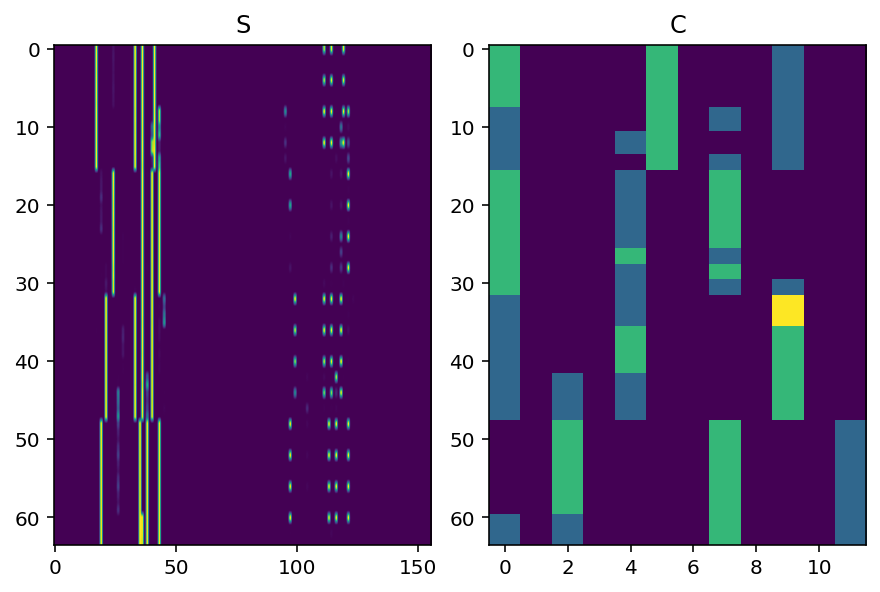

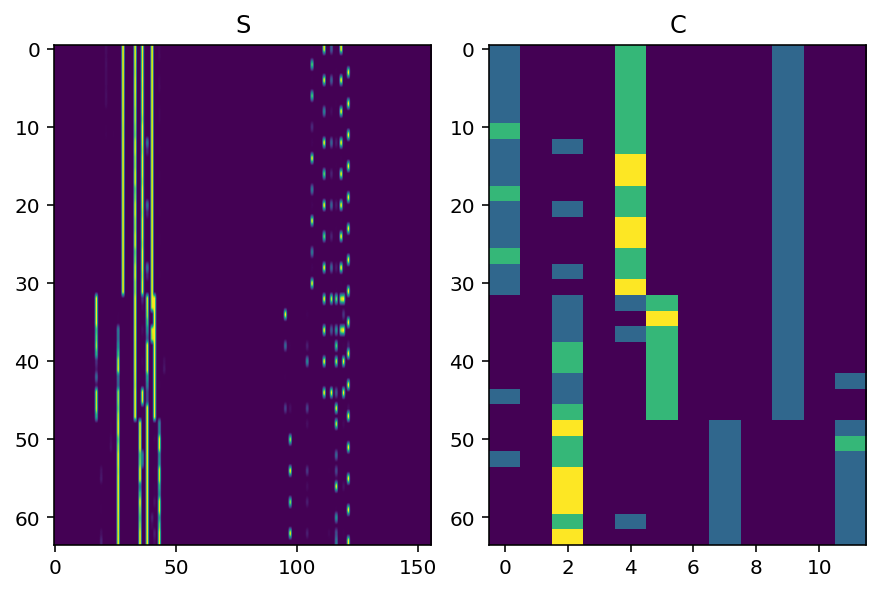

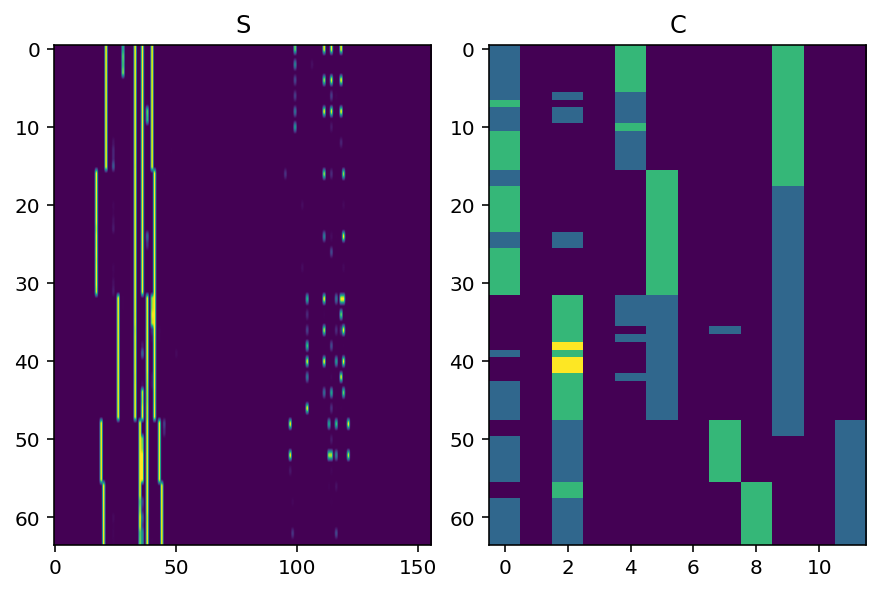

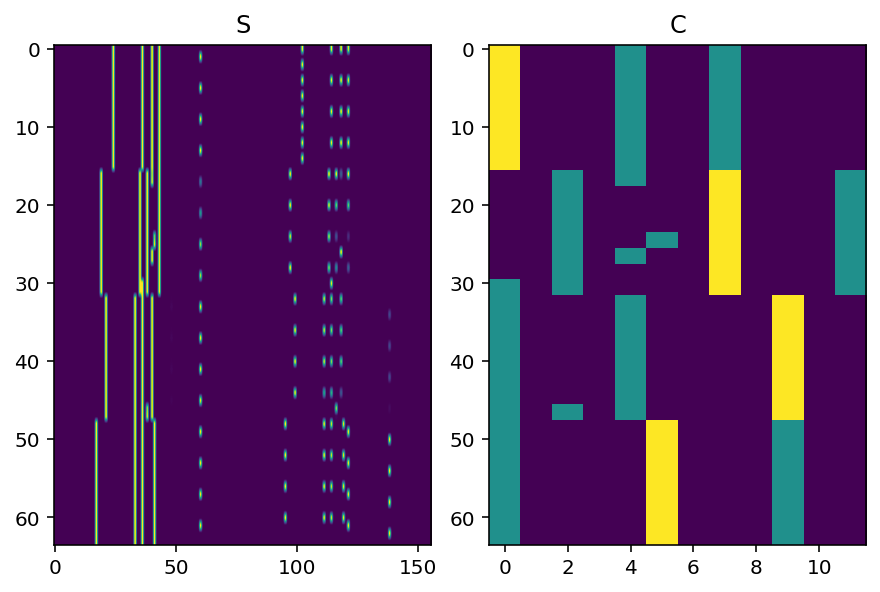

In [53]:
sess_pop, _ = _train_st(pop)

In [54]:
n_samples = 4


for sample, _, _ in (
    _experiment_style_transfer(
        sess_pop, *unzip(
            random.sample(
                list(zip(classical, classical_chromas)), 
                k = n_samples
            )
        )
    )
):
    _midi_to_stream(_pretty_midi_to_music21(sample)).show('midi')

### Conclusion

Musically speaking, the pop to classical style transfer was more successful than classical to pop. This is most likely due to the fact that the chroma features of pop music are much less complex than of classical (as demonstrated by the spectrograms above) thus easier to train.

## Expermment with L1 distance

In [67]:
def _experiment_lambda(Lambda, num_epochs = 200000):
    sess = tf.Session()
    
    D_loss, G_loss = _get_D_G_losses(Lambda = Lambda)
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list = theta_D)
    G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list = theta_G)
    
    sess.run(tf.global_variables_initializer())
    
    return sess, _train(
        sess,
        songs, 
        D_solver, D_loss,
        G_solver, G_loss,
        num_epochs = num_epochs, 
        batch_size = batch_size, 
        checkpoint_fn = _checkpoint
    )

In [68]:
n_num_epochs = 10000

2022-07-24 22:09:11.967740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9649 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


0/10000 D_Loss: 1.545 G_Loss: 6.855


1000/10000 D_Loss: 0.01353 G_Loss: 9.924
2000/10000 D_Loss: 0.0008456 G_Loss: 25.36


3000/10000 D_Loss: 0.005627 G_Loss: 8.435
4000/10000 D_Loss: 0.006129 G_Loss: 26.71
5000/10000 D_Loss: 0.0003581 G_Loss: 10.54


6000/10000 D_Loss: 1.568e-06 G_Loss: 15.94
7000/10000 D_Loss: 0.0009797 G_Loss: 9.603


8000/10000 D_Loss: 1.513e-05 G_Loss: 16.46
9000/10000 D_Loss: 0.0002889 G_Loss: 25.77
10000/10000 D_Loss: 3.408e-07 G_Loss: 18.7


(<tensorflow.python.client.session.Session at 0x7fc8e408fa60>, None)

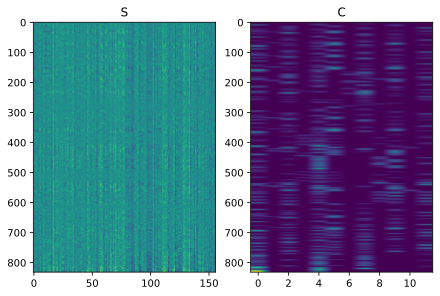

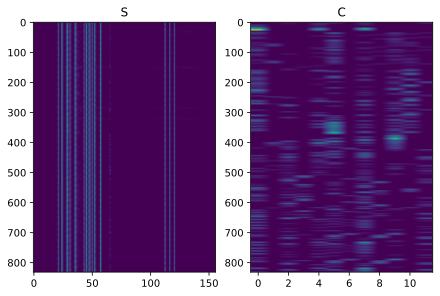

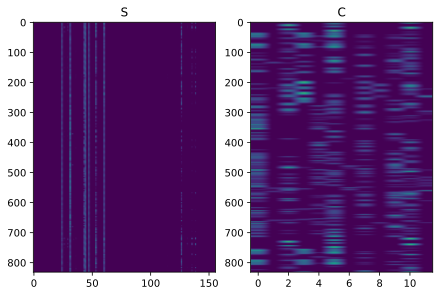

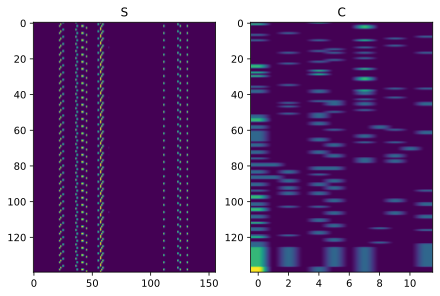

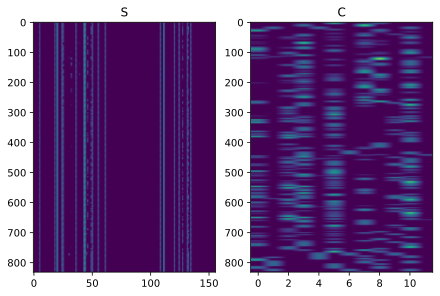

In [69]:
_ = _experiment_lambda(Lambda = 10, num_epochs = n_num_epochs)

2022-07-24 22:11:20.878191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9649 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


0/10000 D_Loss: 1.5 G_Loss: 270.7


1000/10000 D_Loss: 0.09868 G_Loss: 17.88
2000/10000 D_Loss: 0.07608 G_Loss: 18.3


3000/10000 D_Loss: 0.1375 G_Loss: 16.72
4000/10000 D_Loss: 0.03978 G_Loss: 21.86
5000/10000 D_Loss: 0.1172 G_Loss: 19.63


6000/10000 D_Loss: 2.11e-06 G_Loss: 31.1
7000/10000 D_Loss: 1.072e-05 G_Loss: 135.7


8000/10000 D_Loss: 0.1434 G_Loss: 25.78
9000/10000 D_Loss: 0.08229 G_Loss: 23.73
10000/10000 D_Loss: 0.1899 G_Loss: 21.68


(<tensorflow.python.client.session.Session at 0x7fc49904d700>, None)

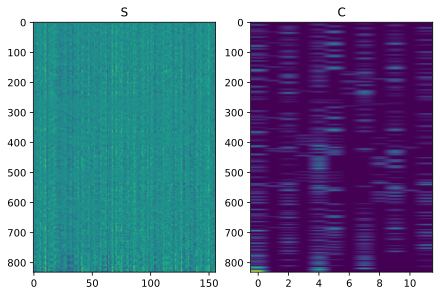

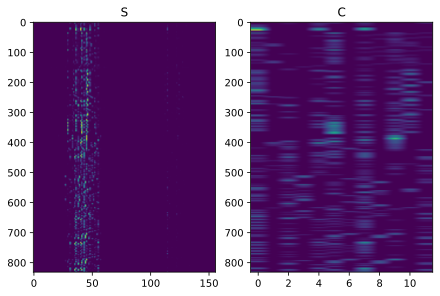

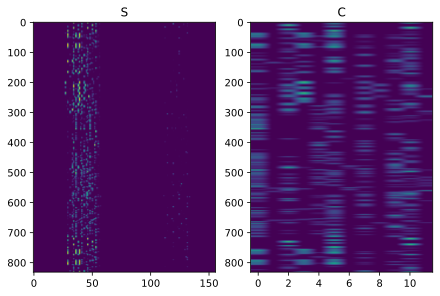

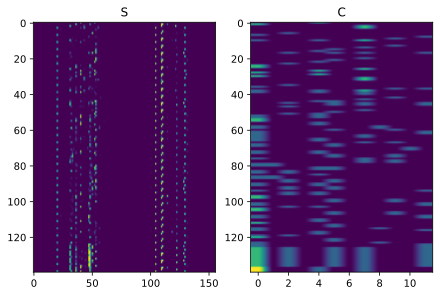

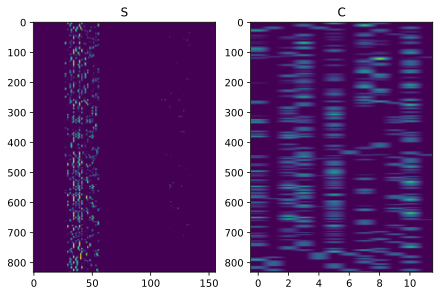

In [70]:
_ = _experiment_lambda(Lambda = 1000, num_epochs = n_num_epochs)

### Conclusion

- What are the effects of such changes? 
- When is the texture of the output more or less musical? 
- Are the harmonic progressions of the input followed or ignored? 
- Any other observations?

Decreasing lambda makes the output less musical, 
while increasing lambda reduces the chance of harmonic progressions being followed.